In [ ]:
"""
Throw Frame Detection using Pose Landmarks and Random Forest

This script extracts motion features (pose, velocity, acceleration) from 
pose landmark sequences, and trains a Random Forest model to detect the 
"throw" frame in javelin throw clips.


"""
# Example: {1: 89, 2: 105, 3: 97}
THROW_FRAMES = {
    # Fill in your manually collected data here
}

import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
import joblib
import matplotlib.pyplot as plt

# ==== CONFIGURATION ====
CLIP_FOLDER = "smoothed_landmarks"
OUTPUT_FOLDER = "predicted_frames"
MODEL_PATH = "throw_frame_detector.pkl"
WINDOW = 7  # Number of frames on each side for context

# Manually annotated dictionary of throw frames
# Format: {clip_id: throw_frame_index}



In [17]:
def extract_features(frames):
    """
    Extract features from a sliding window of pose landmarks.

    Features include:
    - Flattened joint positions
    - Velocity (difference between next and previous)
    - Acceleration (second derivative)

    Args:
        frames (List[np.ndarray]): A sequence of landmark frames

    Returns:
        List[np.ndarray]: List of feature vectors
    """
    features = []
    for i in range(1, len(frames) - 1):
        curr = frames[i].flatten()
        prev = frames[i - 1].flatten()
        next_ = frames[i + 1].flatten()

        velocity = next_ - prev
        acceleration = next_ - 2 * curr + prev

        combined = np.concatenate([curr, velocity, acceleration])
        features.append(combined)
    return features


In [18]:

def train_throw_frame_detector(clip_dir, throw_frames_dict, window=WINDOW):
    """
    Train a Random Forest classifier to detect throw frames.

    Args:
        clip_dir (str): Directory containing landmark `.npy` files
        throw_frames_dict (dict): Ground truth throw frames for each clip
        window (int): Number of context frames on each side

    Returns:
        RandomForestClassifier: Trained classifier
    """
    X, y = [], []

    for fname in sorted(os.listdir(clip_dir)):
        if not fname.endswith(".npy"):
            continue

        try:
            clip_id = int(fname.replace("clip_", "").replace(".npy", ""))
        except ValueError:
            continue

        if clip_id not in throw_frames_dict:
            continue

        landmarks = np.load(os.path.join(clip_dir, fname))
        t_frame = throw_frames_dict[clip_id]

        for idx in range(window, len(landmarks) - window):
            window_frames = landmarks[idx - window:idx + window + 1]
            if len(window_frames) != 2 * window + 1:
                continue

            feats = extract_features(window_frames)
            if feats:
                center_feat = feats[len(feats) // 2]
                X.append(center_feat)
                y.append(1 if idx == t_frame else 0)

    if not X:
        raise ValueError("No valid features extracted from clips.")

    X, y = np.array(X), np.array(y)
    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=5)
    clf.fit(X, y)

    # Save the model
    joblib.dump(clf, MODEL_PATH)
    print(f"Model saved to {MODEL_PATH}")

    return clf


def predict_throw_frame(clf, landmarks, window=WINDOW):
    """
    Predict the most likely throw frame from a clip's landmarks.

    Args:
        clf (RandomForestClassifier): Trained classifier
        landmarks (np.ndarray): Landmark array for a single clip
        window (int): Context window size

    Returns:
        int: Index of predicted throw frame
        List[Tuple[int, float]]: Probability scores for each frame
    """
    preds = []

    for idx in range(window, len(landmarks) - window):
        window_frames = landmarks[idx - window:idx + window + 1]
        if len(window_frames) != 2 * window + 1:
            continue

        feats = extract_features(window_frames)
        if feats:
            prob = clf.predict_proba([feats[len(feats) // 2]])[0][1]
            preds.append((idx, prob))

    if not preds:
        return -1, []

    pred_frame = max(preds, key=lambda x: x[1])[0]
    return pred_frame, preds



In [19]:
def batch_predict_and_save(clf, clip_dir, output_dir, window=WINDOW):
    """
    Predict throw frames for all clips and save the outputs.

    Args:
        clf (RandomForestClassifier): Trained classifier
        clip_dir (str): Directory of `.npy` landmark files
        output_dir (str): Directory to save predictions
        window (int): Window size

    Returns:
        dict: Mapping of clip_id -> predicted frame
    """
    os.makedirs(output_dir, exist_ok=True)
    pred_frames = {}

    for fname in sorted(os.listdir(clip_dir)):
        if not fname.endswith(".npy"):
            continue

        clip_id = int(fname.replace("clip_", "").replace(".npy", ""))
        landmarks = np.load(os.path.join(clip_dir, fname))

        pred_frame, _ = predict_throw_frame(clf, landmarks, window)
        pred_frames[clip_id] = pred_frame

        # Save predicted frame
        np.save(os.path.join(output_dir, f"clip_{clip_id}_pred_throw_frame.npy"), np.array([pred_frame]))

    return pred_frames


In [20]:
def evaluate_predictions(predicted, actual):
    """
    Compare predicted throw frames with actual ground truth.
    """
    y_true, y_pred = [], []
    for clip_id, true_frame in actual.items():
        if clip_id in predicted:
            y_true.append(true_frame)
            y_pred.append(predicted[clip_id])

    if not y_true:
        print("No valid predictions to evaluate.")
        return

    errors = [abs(t - p) for t, p in zip(y_true, y_pred)]
    accuracy = sum(1 for e in errors if e == 0) / len(errors)
    avg_error = np.mean(errors)

    print(f"\nEvaluation Summary:")
    print(f"Exact match accuracy: {accuracy * 100:.2f}%")
    print(f"Average frame error: {avg_error:.2f} frames")

    return y_true, y_pred


def plot_predictions(y_true, y_pred):
    """
    Plot predicted vs actual throw frames.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Throw Frame', marker='o')
    plt.plot(y_pred, label='Predicted Throw Frame', marker='x')
    plt.title("Predicted vs Actual Throw Frames")
    plt.xlabel("Clip Index")
    plt.ylabel("Frame Number")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Model saved to throw_frame_detector.pkl

Evaluation Summary:
Exact match accuracy: 97.37%
Average frame error: 0.04 frames


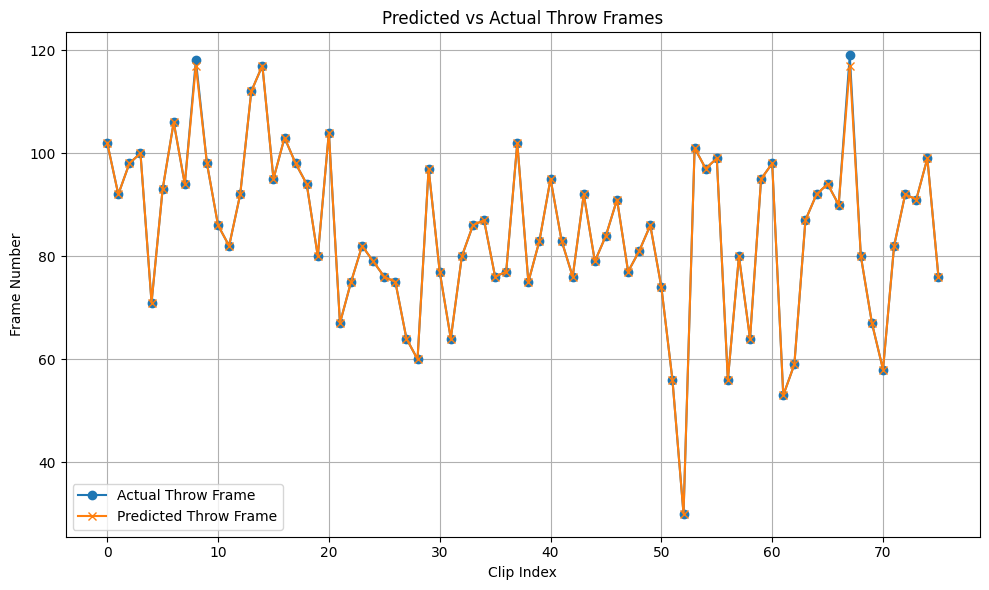

In [21]:
# ==== MAIN ====
if __name__ == "__main__":
    # Train the model
    clf = train_throw_frame_detector(CLIP_FOLDER, THROW_FRAMES, window=WINDOW)

    # Predict throw frames for all clips
    PRED_FRAMES = batch_predict_and_save(clf, CLIP_FOLDER, OUTPUT_FOLDER, window=WINDOW)

    # Evaluate and visualize results
    true_frames, predicted_frames = evaluate_predictions(PRED_FRAMES, THROW_FRAMES)
    plot_predictions(true_frames, predicted_frames)